In [1]:
# 乳腺癌诊断

import numpy as np
import pandas as pd
from sklearn.datasets import load_breast_cancer  # 乳腺癌数据集
from sklearn.model_selection import train_test_split  # 分割数据集
from sklearn.preprocessing import StandardScaler  # 特征标准化（逻辑回归必需）
from sklearn.linear_model import LogisticRegression  # 逻辑回归模型
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score  # 评估指标


In [14]:
# 准备数据

data = load_breast_cancer()
x = data.data
y = data.target
print("特征形状： ",x.shape)
print("标签分布：", pd.Series(y).value_counts())


特征形状：  (569, 30)
标签分布： 1    357
0    212
Name: count, dtype: int64


In [24]:
# 分割训练集（80%）和测试集（20%）
x_train, x_test, y_train, y_test = train_test_split(
    x, y, test_size=0.2, random_state=42, stratify=y  # stratify=y：保持标签分布一致
)

# 特征标准化
scaler = StandardScaler()  # 标准化为均值0，标准差1
X_train_scaled = scaler.fit_transform(x_train)  # 用训练集拟合并转换
X_test_scaled = scaler.transform(x_test)        # 用训练集的scaler转换测试集（避免数据泄露）


# 初始化模型（处理轻微不平衡数据，用balanced权重）
model = LogisticRegression(
    penalty='l2',          # L2正则化
    C=1.0,                 # 正则化强度（可后续调优）
    solver='sag',        # 优化器（适合多分类和中等数据集）
    class_weight='balanced',  # 自动平衡类别权重
    max_iter=1000,         # 增加迭代次数确保收敛
    random_state=42
)

# 训练模型
model.fit(X_train_scaled, y_train)

,penalty,'l2'
,dual,False
,tol,0.0001
,C,1.0
,fit_intercept,True
,intercept_scaling,1
,class_weight,'balanced'
,random_state,42
,solver,'sag'
,max_iter,1000
,multi_class,'deprecated'


In [25]:
# 特征权重（coef_）：正值表示该特征与“良性（1）”正相关，负值与“恶性（0）”正相关
feature_weights = pd.DataFrame({
    "特征名": data.feature_names,
    "权重": model.coef_[0]  # 二分类时coef_形状为(1, n_features)
}).sort_values(by="权重", ascending=False)  # 按权重排序

print("特征权重（前3名和后3名）：\n", feature_weights.iloc[[0,1,2,-3,-2,-1]])

特征权重（前3名和后3名）：
                         特征名        权重
5          mean compactness  0.759628
15        compactness error  0.656648
19  fractal dimension error  0.435476
27     worst concave points -0.996112
10             radius error -1.154903
21            worst texture -1.279259


In [27]:
# 预测类别和概率
y_pred = model.predict(X_test_scaled)  # 类别预测（0/1）
y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]  # 属于良性（1）的概率

# 评估指标
print("准确率（Accuracy）：", accuracy_score(y_test, y_pred))  # 约0.9737
print("\n分类报告（Precision/Recall/F1）：")
print(classification_report(y_test, y_pred,labels=[0,1],target_names=["良性",'恶性']))
print("\nAUC值（ROC曲线下面积）：", roc_auc_score(y_test, y_pred_proba))  # 约0.995（接近1，效果好）

准确率（Accuracy）： 0.956140350877193

分类报告（Precision/Recall/F1）：
              precision    recall  f1-score   support

          良性       0.91      0.98      0.94        42
          恶性       0.99      0.94      0.96        72

    accuracy                           0.96       114
   macro avg       0.95      0.96      0.95       114
weighted avg       0.96      0.96      0.96       114


AUC值（ROC曲线下面积）： 0.9953703703703703


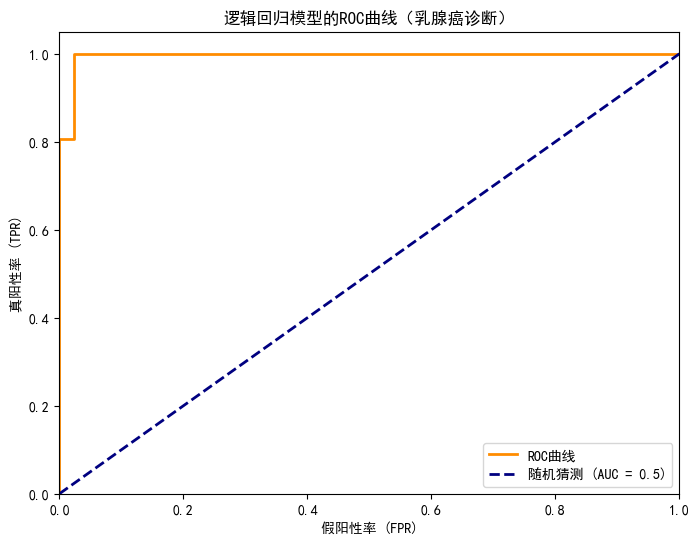

In [30]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve

# 1. 计算FPR（假阳性率）、TPR（真阳性率）和阈值
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)

# 3. 设置中文显示（避免乱码）
plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams["axes.unicode_minus"] = False  # 正确显示负号

# 4. 绘制ROC曲线
plt.figure(figsize=(8, 6))
# 绘制ROC曲线
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC曲线')
# 绘制随机猜测的基准线（对角线）
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--', label='随机猜测 (AUC = 0.5)')

# 5. 设置坐标轴和标题
plt.xlim([0.0, 1.0])  # 横轴范围
plt.ylim([0.0, 1.05])  # 纵轴范围（略大于1，便于显示）
plt.xlabel('假阳性率 (FPR)')  # FPR：非癌症（0）被误判为癌症（1）的比例
plt.ylabel('真阳性率 (TPR)')  # TPR：癌症（1）被正确判为癌症（1）的比例（即召回率）
plt.title('逻辑回归模型的ROC曲线（乳腺癌诊断）')
plt.legend(loc="lower right")  # 图例位置

# 6. 显示图像
plt.show()
